In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix


In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Convert boolean columns to integers
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

# Normalize numerical columns
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

# Save the scalers for future use
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")

# Save the preprocessed dataset
data.to_csv("newphishdata.csv", index=False)


Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Split dataset into features and target variable
X = data.drop(columns=['phishing'])
y = data['phishing']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape data for DBN (samples, features)
X_train_dbn = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1])
X_test_dbn = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1])


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers

# class NeuralFieldAttention(layers.Layer):
#     def __init__(self, lambda_strength=0.1, **kwargs):
#         super(NeuralFieldAttention, self).__init__(**kwargs)
#         self.lambda_strength = lambda_strength

#     def build(self, input_shape):
#         feature_dim = input_shape[-1]
#         self.kernel = self.add_weight(
#             shape=(feature_dim, feature_dim),
#             initializer='glorot_uniform',
#             trainable=True,
#             name='interaction_kernel'
#         )
#         super().build(input_shape)

#     def call(self, inputs):
#         I = inputs  # [batch_size, feature_dim]
#         u = tf.zeros_like(I)

#         # Precompute mean to avoid dynamic operations
#         I_mean = tf.reduce_mean(I, axis=1, keepdims=True)
#         delta = tf.reduce_mean(tf.abs(I - I_mean), axis=-1, keepdims=True)
#         delta = tf.tile(delta, [1, I.shape[-1]])

#         # Apply interaction and attention
#         interaction = tf.matmul(I, self.kernel)
#         activation = tf.nn.relu(u)
#         u = u + (-u + interaction + I + self.lambda_strength * delta)

#         # Apply attention scores and compute attended output
#         attention_scores = tf.nn.softmax(u, axis=1)
#         attended_output = tf.reduce_sum(attention_scores * I, axis=1)

#         return attended_output

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "lambda_strength": self.lambda_strength
#         })
#         return config


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the custom NeuralFieldAttention layer
class NeuralFieldAttention(tf.keras.layers.Layer):
    def __init__(self, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super().build(input_shape)

    def call(self, inputs):
        I = inputs  # [batch_size, feature_dim]
        u = tf.zeros_like(I)

        # Precompute mean to avoid dynamic operations
        I_mean = tf.reduce_mean(I, axis=1, keepdims=True)
        delta = tf.reduce_mean(tf.abs(I - I_mean), axis=-1, keepdims=True)
        delta = tf.tile(delta, [1, I.shape[-1]])

        # Apply interaction and attention
        interaction = tf.matmul(I, self.kernel)
        activation = tf.nn.relu(u)
        u = u + (-u + interaction + I + self.lambda_strength * delta)

        # Apply attention scores and compute attended output
        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * I, axis=1)

        return attended_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_strength": self.lambda_strength
        })
        return config

# Build DBN Model with Attention
dbn_model = Sequential()

# Add input layer (input shape for DBN, e.g., feature_dim)
dbn_model.add(Input(shape=(X_train.shape[1],)))

# Fully connected layers (DBN part)
dbn_model.add(Dense(128, activation='relu'))
dbn_model.add(Dropout(0.2))
dbn_model.add(Dense(64, activation='relu'))
dbn_model.add(Dropout(0.2))
dbn_model.add(Dense(32, activation='relu'))
dbn_model.add(Dropout(0.2))

# Add Neural Field Attention after the first feature extraction
dbn_model.add(NeuralFieldAttention(lambda_strength=0.2))

# Reshape the output of Neural Field Attention to have shape (None, 1)
dbn_model.add(tf.keras.layers.Reshape((1,)))

# Fully connected layers after attention mechanism
dbn_model.add(Dense(128, activation='relu'))
dbn_model.add(Dropout(0.3))
dbn_model.add(Dense(64, activation='relu'))
dbn_model.add(Dropout(0.2))

# Output layer
dbn_model.add(Dense(1, activation='sigmoid'))

# Compile model
dbn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

dbn_model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_field_attention_1        │ (None)                 │         1,024 │
│ (NeuralFieldAttention)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,273 (133.88 KB)

 Trainable params: 34,273 (133.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = tf.keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)



In [ ]:
# Train the DBN model
history = dbn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, time_callback],
    verbose=1
)



Epoch 1/50
1086/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9384 - Precision: 0.7911 - Recall: 0.9167 - accuracy: 0.8847 - loss: 0.3288Epoch 1 Time: 13.07s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - AUC: 0.9385 - Precision: 0.7913 - Recall: 0.9167 - accuracy: 0.8848 - loss: 0.3283 - val_AUC: 0.9800 - val_Precision: 0.9262 - val_Recall: 0.8395 - val_accuracy: 0.9205 - val_loss: 0.1971
Epoch 2/50
1089/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9754 - Precision: 0.8759 - Recall: 0.9132 - accuracy: 0.9240 - loss: 0.1881Epoch 2 Time: 7.19s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.9754 - Precision: 0.8759 - Recall: 0.9132 - accuracy: 0.9240 - loss: 0.1881 - val_AUC: 0.9814 - val_Precision: 0.8981 - val_Recall: 0.8974 - val_accuracy: 0.9285 - val_loss: 0.1733
Epoch 3/50
1090/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9769 - Precision: 0.8740 - Recall: 0.9205 - accuracy: 0.9260 - loss: 0.1819Epoch 3 Time: 9.26s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.9769 -

In [ ]:
y_pred = (dbn_model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# FAR & FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Metrics:
Accuracy: 0.9555
Precision: 0.9414
Recall: 0.9305
AUC: 0.9497
Confusion Matrix:
[[10990   353]
 [  424  5675]]

FAR: 0.0311
FRR: 0.0695


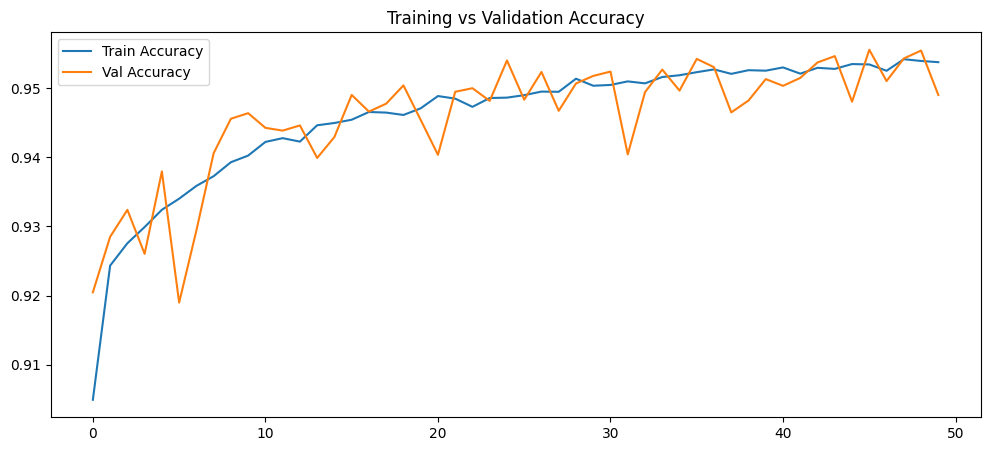

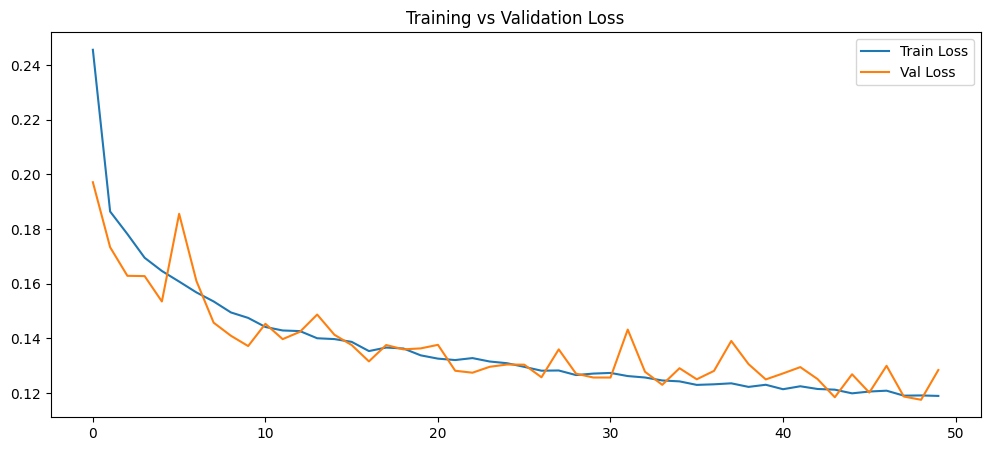

In [ ]:
np.save("model_history_dbn.npy", history.history)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Save model history
np.save("model_history_dbn.npy", history.history)

# Plot Accuracy (smaller figure, square-ish ratio)
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss (smaller figure, square-ish ratio)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
